In [2]:
import torch
import torch.nn as nn
from torch.distributions import Categorical
import numpy as np
from tqdm.notebook import tqdm
from models.ann import DeepQNet
from gridworld.agent import Agent
from gridworld.world import LoggerTrainingWorld

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device: ', device)
print('Torch: ', torch.__version__)

load_model_name = None#'policy_2023-07-18_13-15.pth'

num_epochs: int = 250

episode_duration: int = 128
num_episodes_per_epoch: int = 8

num_batches_per_epoch: int = 32
batch_size: int = 32

discount_factor = 0.9
learning_rate = 1e-3

random_exploration_decay = 0.99
initial_p_explore = 1.0

agent = Agent()

policy = DeepQNet()
loss_history = []

# Load models
if not load_model_name is None:
    policy.load_state_dict(torch.load(load_model_name))
policy = policy.to(device)

class ReplayMemory:
    def __init__(self) -> None:
        self.observations = torch.zeros((0, (agent.vision_range * 2 + 1)**2), dtype=torch.int32).to(device)
        self.actions = torch.zeros((0, 1), dtype=torch.int32).to(device)
        self.rewards = torch.zeros(0).to(device)
        
    def add_experience(self, observation: torch.Tensor, actions: torch.Tensor, rewards: torch.Tensor, add_discount: bool = True) -> None:
        if add_discount:
            rewards = compute_discounted_rewards(rewards, discount_factor)
        self.observations = torch.cat((self.observations, observation.to(device)))
        self.actions = torch.cat((self.actions, actions.to(device)))
        self.rewards = torch.cat((self.rewards, rewards.to(device)))
        
    def make_batch(self, batch_size: int):
        indices = np.random.randint(0, len(self.observations), batch_size)
        memory = ReplayMemory()
        memory.add_experience(self.observations[indices], self.actions[indices], self.rewards[indices])
        return memory

def compute_discounted_rewards(rewards: torch.Tensor, discount_factor: float) -> torch.Tensor:
    num_steps = len(rewards)
    discounted_rewards = torch.zeros(num_steps)
    cumulative_reward = 0

    for t in reversed(range(num_steps)):
        cumulative_reward = rewards[t] + discount_factor * cumulative_reward
        discounted_rewards[t] = cumulative_reward

    return discounted_rewards

def simulate_episode(agent: Agent, p_random_action) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, int]:
    world = LoggerTrainingWorld()
    agent.x, agent.y = world.get_random_coordinates()
    observations = torch.zeros((episode_duration, (agent.vision_range * 2 + 1)**2), dtype=torch.int32)
    actions = torch.zeros((episode_duration, 1), dtype=torch.int32)
    rewards = torch.zeros(episode_duration, 1, dtype=torch.float32)
    
    t = 0
    action: int = 0
    for t in range(episode_duration):
        visual_field = world.get_visual_field_at_agent(agent).flatten().to(device)
        if torch.rand(1) < p_random_action:
            action: int = np.random.randint(0, len(agent.actions))
        else:
            probs = torch.zeros(len(agent.actions)).to(device)
            for action in range(len(agent.actions)):
                probs[action] = policy(visual_field.unsqueeze(dim=0), torch.tensor([action]).to(device).unsqueeze(dim=0))
            #action = int(torch.argmax(rewards).cpu().item())
            prob_dist = Categorical(probs)
            action = int(prob_dist.sample().item())
        
        observations[t] = visual_field
        actions[t] = action
        rewards[t] = agent.step(action, world)
        
    return observations[:t], actions[:t], rewards[:t], t

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(policy.parameters(), lr=learning_rate)
#policy.compile(loss=loss_fn, optimizer=optimizer, metrics=['mse'])

p_random_exploration = initial_p_explore
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    memories = ReplayMemory()
    running_loss = 0.0
    for episode in range(num_episodes_per_epoch):
        observations, actions, rewards, duration = simulate_episode(agent, p_random_exploration)
        memories.add_experience(observations, actions, rewards)

    for batch in range(num_batches_per_epoch):
        batch_data = memories.make_batch(batch_size)
        optimizer.zero_grad()
        predicted_rewards = policy(batch_data.observations, batch_data.actions)
        loss = loss_fn(predicted_rewards, batch_data.rewards.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    loss_history.append(running_loss / num_batches_per_epoch)
    p_random_exploration *= random_exploration_decay

Device:  cuda
Torch:  2.0.1+cu117


Epochs:   0%|          | 0/250 [00:00<?, ?it/s]

In [ ]:
import datetime
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
filename = f"policy_{timestamp}.pth"
torch.save(policy.state_dict(), filename)

Final loss: 0.3391216513700783


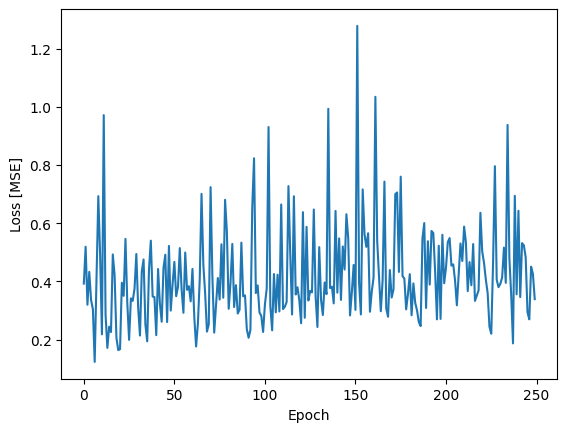

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss [MSE]')
print('Final loss:', loss_history[-1])